In [52]:
%pip install ipykernel numpy pandas matplotlib seaborn scikit-learn xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Підготовчий етап
**Датасет:** California Housing Prices [https://www.kaggle.com/datasets/camnugent/california-housing-prices](https://www.kaggle.com/datasets/camnugent/california-housing-prices)

1. Провести аналіз вибраного набору даних,
1. визначити вхідні та вихідні параметри,
1. візуалізувати залежності входів та виходу,
1. детектувати аномалії, неповні зразки у даних, тощо,
1. провести кореляційний аналіз входів та виходів набору даних, виявити взаємозалежні фактори.
1. Провести підготовку даних до подальшого використання.
1. Обраний та відфільтрований набір даних розбити на навчальну та тестову частину (70% на навчання, 30% на тест).

In [53]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_california_housing

import time
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb

In [ ]:
data = pd.read_csv("Data/housing.csv")
print(data.shape)
data.head()

(20640, 9)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


## Провести аналіз вибраного набору даних,

In [61]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


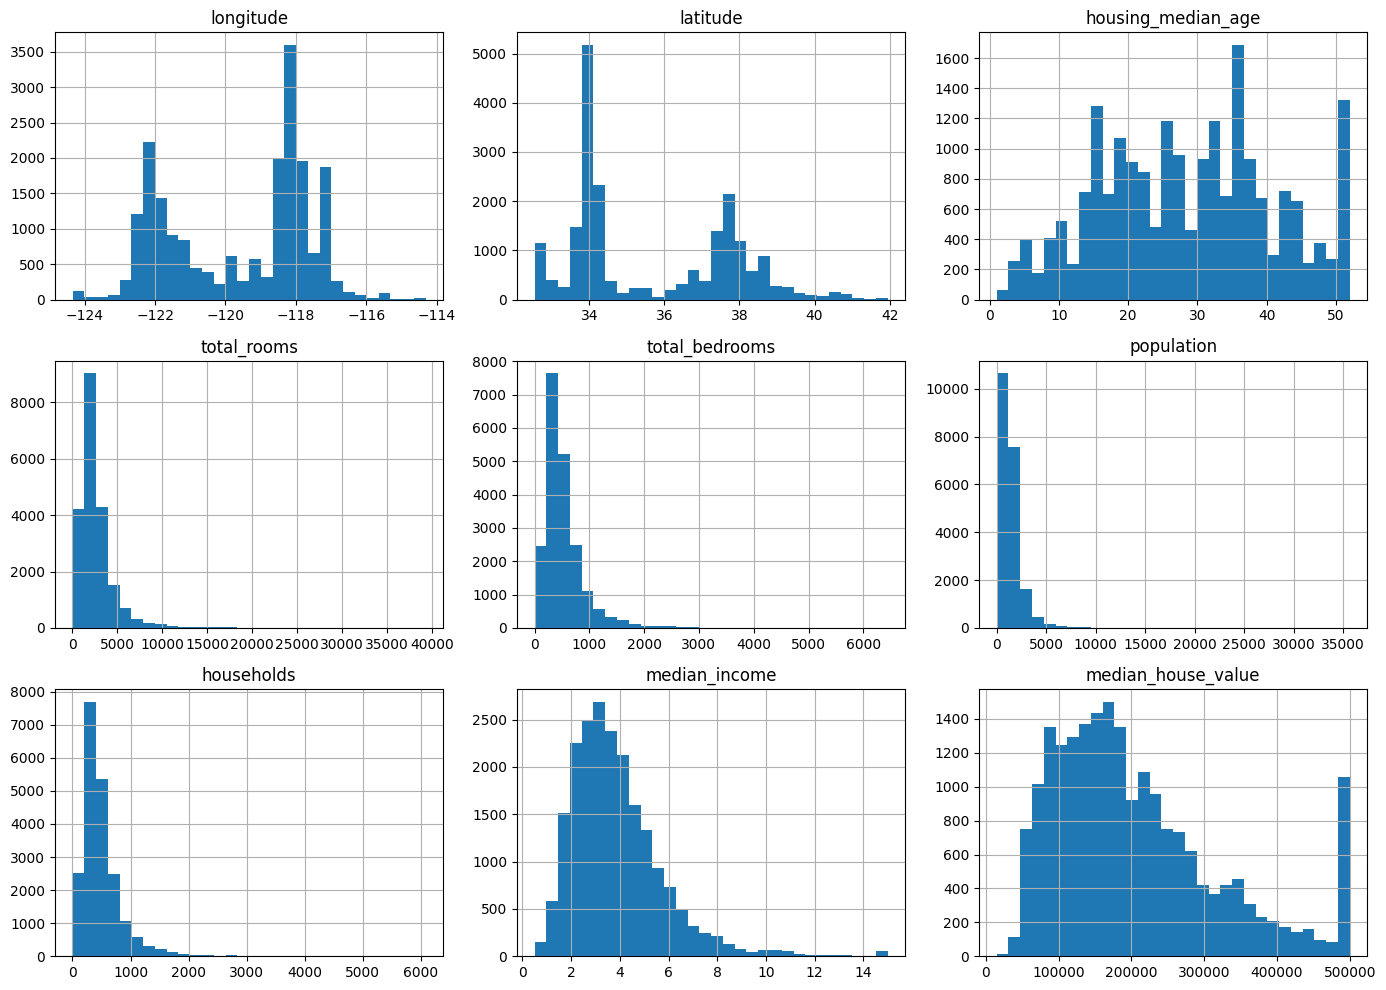

In [56]:
data.hist(bins=30, figsize=(14,10))
plt.tight_layout()
plt.show()


In [ ]:
# data = data.drop(columns=["ocean_proximity"])

## Визначити вхідні та вихідні параметри,

## Візуалізувати залежності входів та виходу,

## Детектувати аномалії, неповні зразки у даних, тощо,

In [75]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


Кількість total_bedrooms менше ніж в інших, є НаН

Дуже дивне значення коштування дому 500001.00

In [67]:
data.total_bedrooms.value_counts(dropna=False)

total_bedrooms
NaN       207
280.0      55
331.0      51
345.0      50
343.0      49
         ... 
2009.0      1
2249.0      1
3114.0      1
1625.0      1
1742.0      1
Name: count, Length: 1924, dtype: int64

In [74]:
data[data.total_bedrooms.isna()]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0
...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0
20372,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0
20460,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,258100.0


## Провести кореляційний аналіз входів та виходів набору даних, виявити взаємозалежні фактори.

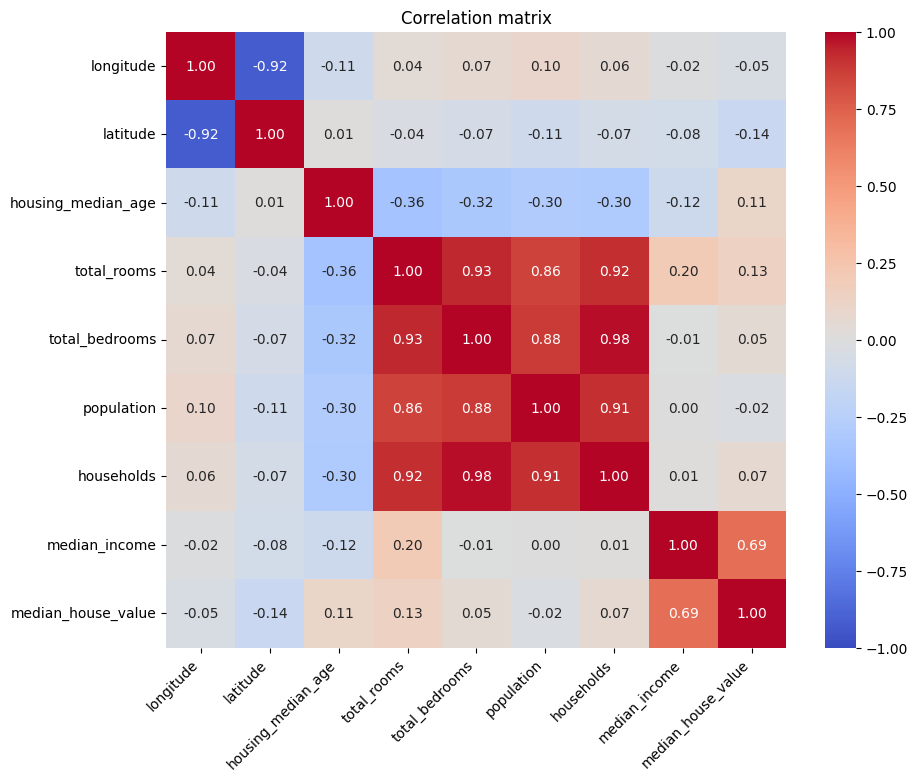

In [57]:
corr = data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(rotation=45, ha='right')
plt.title('Correlation matrix')
plt.show()


## Провести підготовку даних до подальшого використання.

In [58]:
df_fe = data.copy()

df_fe['rooms_per_household'] = df_fe['total_rooms'] / df_fe['households']
df_fe['bedrooms_per_room'] = (df_fe['total_bedrooms'] / df_fe['households']) / (df_fe['rooms_per_household'])   # + 1e-6
df_fe['population_per_household'] = df_fe['population'] / df_fe['households']

df_fe['log_median_house_value'] = np.log1p(df_fe['median_house_value'])

df_fe[['rooms_per_household','bedrooms_per_room','population_per_household', 'log_median_house_value']].head()

,rooms_per_household,bedrooms_per_room,population_per_household,log_median_house_value
0,6.984127,0.146591,2.555556,13.022766
1,6.238137,0.155797,2.109842,12.789687
2,8.288136,0.129516,2.802260,12.771673
3,5.817352,0.184458,2.547945,12.740520
4,6.281853,0.172096,2.181467,12.743154


## Обраний та відфільтрований набір даних розбити на навчальну та тестову частину (70% на навчання, 30% на тест).

In [59]:
features = df_fe.columns.drop(['median_house_value', 'log_median_house_value'])
X = df_fe[features].copy()
y = df_fe['median_house_value'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

X_train_scaled.shape, X_test_scaled.shape


((14448, 11), (6192, 11))

# Реалізація моделі

1. SciKit learn
1. XGBoost
1. Vanilla Python (Numpy/Pandas)

## SciKit learn

## XGBoost

## Vanilla Python (Numpy/Pandas)

# Аналіз результатів

1. Вибір оптимальних параметрів регресій, їх обгрунтування
2. Оцінка помилок на начальній та тестовій вибірках
3. Порівняння результатів різних підходів (співпали чи ні, причини чому могли не співпасти, runtime тощо)
4. Порівняти результати з аналогічними результатами, які отримані в результаті використання вбудованих функцій
5. Результати оформити протоколом

## Вибір оптимальних параметрів регресій, їх обгрунтування

## Оцінка помилок на начальній та тестовій вибірках

## Порівняння результатів різних підходів

## Порівняти результати з аналогічними результатами, які отримані в результаті використання вбудованих функцій

## Результати

# Контрольні питання

1. **Що таке ансамблювання та для чого воно використовується?**
Ансамблювання — поєднання кількох моделей для отримання кращої узагальнюючої здатності. Зазвичай знижує дисперсію (bagging), зміщення (boosting) або отримує кращу стабільність (stacking, voting).

2. **Які моделі базуються на принципі лінійної регресії?**
OLS (ordinary least squares), Ridge, Lasso, ElasticNet, Logistic Regression (для класифікації — перетворення цілі), Bayesian Linear Regression, Elastic Net тощо.

3. **Що таке XGBoost?**
XGBoost — ефективна імплементація градієнтного бустингу дерев рішень з оптимізаціями по швидкості та пам'яті, регуляризацією, обробкою відсутніх значень і ранньою зупинкою.
